# PySPPL: Introduction

## PySPPL imports

In [ ]:
%matplotlib inline
from pyppl import compile_model 
from pyppl.utils.core import create_network_graph, display_graph


## A statistical model with basic control-flow

For fun, let us add some contextual data: Whether or not Alice decides to go to space is highly dependedent upon the number points Alice collects, which is dependent upon a draw from a centered normal distribution. If she draws a number greater than 0, then we observe that Alice gets 1.5 points and the likelihood she goes to space, given the 1.5 points is distributed by $\mathcal{N}(1.5~|~x_1,1)$. However, if she draws a number less than or equal to 0, then her likelihood is quite different. She gains 1 point, but the likelihood that the distribution is centered around 1, is dependedent upon a random draw from a categorical distrubtion that spits out 0 with probability 0.1, 1 with probability 0.2, and 2 with probability 0.7. If we find that the value of the $x_1$ after the inference is greater than zero, then Alice goes to space, else she stays on Earth :-(


$$ x_1 \sim \mathcal{N}(0,1) $$
$$ x_2 \sim \mathcal{Cat}(0.1, 0.2, 0.7) $$
we observe, our data, 
$$y_1 = 1.5 $$
$$y_2 = 1 $$

likelihood terms
$$ y_1 = 1.5~|~x_1 = \mathcal{N}(y_1~|~x_1,~1) $$
$$ y_2 = 1~|~x_2 = \mathcal{N}(y_2~|~x_2,~1) $$


In [11]:
model_if_clojure="""
(let [x1 (sample (normal 0 1))
      x2 (sample (categorical [0.1 0.2 0.7]))
      y1 2
      y2 4]
  (if (> x1 0)
    (observe (normal x1 1) y1)
    (observe (normal x2 1) y2))
  [x1 x2])
"""


compiled_clojure = compile_model(model_if_clojure, language='clojure')

TypeError: compile_model() missing 1 required positional argument: 'source'

The compiler takes the above code and transforms it into a model class, from which the user can manipulate the program and interface with an inference engine. 

Here is a print out of the model class for the above model:

In [ ]:
print(compiled_clojure.code)

We can change the models imported by changing the arguements in the `compile_model` function. By specification to our current application the compiler automatically imports `pytorch`. This can be easily removed by going into `ppl_graph_codeden` and then removing the `if not has_dist` block. 

In [16]:
compile_clojure = compile_model(model_if_clojure, language='clojure',imports='import matplotlib as mpl \nimport numpy as np ')
print(compile_clojure.code)

# 2018-06-11 16:01:03.399927
import torch.distributions as dist
from pyppl.aux.graph_plots import GraphPlotter as _GraphPlotter
import matplotlib as mpl 
import numpy as np 

class Model(_GraphPlotter):

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def g

## Printing the graphical model of the stastical model. 

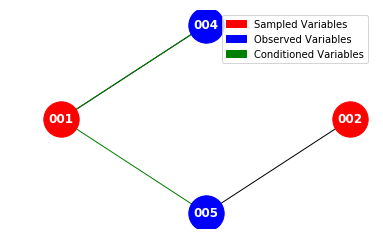

True

In [3]:
vertices = compiled_clojure.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices)

We can see from the graph that $x_2$ is only dependent on the observation $y_2$, whereas $x_1$ can be affected by both observations. 

##  An example of an independent Categorical model

The below model is completely impratical as a statistical model. It is purely here to show what happens when every variable in the model is independent.

In [4]:
model_categorical = """
(let[z (sample (categorical [0.7 0.15 0.15]))
    z1 (sample (categorical [0.1 0.5 0.4]))
    z2 (sample (categorical [0.2 0.2 0.6]))]
    z z1 z2)"""

In [5]:
compiled_clojure = compile_model(model_categorical, language='clojure')
# print(compiled_clojure.code)
vertices = compiled_clojure.vertices

### Plotting the depndence graph

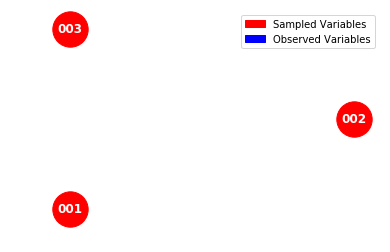

True

In [6]:
create_network_graph(vertices=vertices)
display_graph(vertices=vertices)

As you can see, in this model there are no dependencies between the different latent variables.

## A Hidden Markov Model

In [17]:
model_hmm_clojure="""
(defn data [n]
  (let [points (vector 0.9 0.8 0.7 0.0 -0.025
                       5.0 2.0 0.1 0.0 0.13
                       0.45 6.0 0.2 0.3 -1.0 -1.0)]
    (get points n)))

;; Define the init, transition, and observation distributions
(defn get-init-params []
  (vector (/ 1. 3.) (/ 1. 3.) (/ 1. 3.)))

(defn get-trans-params [k]
  (nth (vector (vector 0.1  0.5  0.4 )
               (vector 0.2  0.2  0.6 )
               (vector 0.7 0.15 0.15 )) k))

(defn get-obs-dist [k]
  (nth (vector (normal -1. 1.)
               (normal  1. 1.)
               (normal  0. 1.)) k))

;; Function to step through HMM and sample latent state
(defn hmm-step [n states]
  (let [next-state (sample (categorical (get-trans-params (last states))))]
    (observe (get-obs-dist next-state) (data n))
    (conj states next-state)))

;; Loop through the data
(let [init-state (sample (categorical (get-init-params)))]
  (loop 16 (vector init-state) hmm-step))

"""

### Plotting the dependencies graph

In [18]:
compiled_clojure = compile_model(model_hmm_clojure, language='clojure')
vertices = compiled_clojure.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices)

AttributeError: 'NoneType' object has no attribute 'startswith'

# PySPPL for python based models

PySPPLs design allows one to use it with many different langauges, we so far have built an interface for both `python` and `clojure` code. 